In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
training_data = image_dataset_from_directory(
    '../data/chest_xray/train', 
    labels='inferred',
    validation_split = 0.2,
    subset="training",
    seed=14)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.


In [3]:
validation_data = image_dataset_from_directory(
    '../data/chest_xray/train', 
    labels='inferred',
    validation_split = 0.2,
    subset="validation",
    seed=14)

Found 5216 files belonging to 2 classes.
Using 1043 files for validation.


In [4]:
test_data = image_dataset_from_directory(
    '../data/chest_xray/test', 
    labels='inferred',
    batch_size = 624,
    shuffle = False)

Found 624 files belonging to 2 classes.


In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [6]:
aug_ds = training_data.map( lambda x, y: (data_augmentation(x, training=True), y))
augmented_training_data = training_data.concatenate(aug_ds)

In [7]:
aug_val = validation_data.map( lambda x, y: (data_augmentation(x, training=True), y))
augmented_validation_data = validation_data.concatenate(aug_val)

In [8]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [9]:
augmented_training_data = augmented_training_data.shuffle(1000)
augmented_training_data = augmented_training_data.map(preprocess).prefetch(1)
augmented_validation_data = augmented_validation_data.map(preprocess).prefetch(1)
test_data = test_data.map(preprocess).prefetch(1)

In [10]:
augmented_training_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
base_model = keras.applications.xception.Xception(weights = 'imagenet', include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation = 'sigmoid')(avg)
model = keras.Model(inputs = base_model.input, outputs = output)

In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9, decay = 0.01)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [14]:
results = model.fit(augmented_training_data, epochs = 6, validation_data = augmented_validation_data, class_weight = {0:2.88, 1:1})


Epoch 1/6
262/262 [==============================] - 592s 2s/step - loss: 3.2409 - accuracy: 0.8792 - val_loss: 1.6364 - val_accuracy: 0.8974
Epoch 2/6
262/262 [==============================] - 572s 2s/step - loss: 1.0574 - accuracy: 0.9351 - val_loss: 0.6624 - val_accuracy: 0.9310
Epoch 3/6
262/262 [==============================] - 570s 2s/step - loss: 0.6488 - accuracy: 0.9446 - val_loss: 0.5552 - val_accuracy: 0.9382
Epoch 4/6
262/262 [==============================] - 574s 2s/step - loss: 0.5810 - accuracy: 0.9418 - val_loss: 0.6264 - val_accuracy: 0.9209
Epoch 5/6
262/262 [==============================] - 569s 2s/step - loss: 0.4760 - accuracy: 0.9487 - val_loss: 0.6369 - val_accuracy: 0.9113
Epoch 6/6
262/262 [==============================] - 568s 2s/step - loss: 0.4470 - accuracy: 0.9486 - val_loss: 0.4546 - val_accuracy: 0.9305


In [15]:
model.evaluate(test_data)

1/1 [==============================] - 0s 40ms/step - loss: 1.5247 - accuracy: 0.8349


[1.5247061252593994, 0.8349359035491943]

In [ ]:
#model.save('Kyle_transfer_2')

# Run for a few epochs, then unfreeze the bottom layers and resume training below

In [16]:
for layer in base_model.layers:
    layer.trainable = True

In [17]:
optimizer = keras.optimizers.SGD(lr = 0.01, momentum = 0.9, decay = 0.001)
model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [18]:
results = model.fit(augmented_training_data, epochs = 10, validation_data = augmented_validation_data, class_weight = {0:2.88, 1:1})

Epoch 1/10
262/262 [==============================] - 2165s 8s/step - loss: 0.3038 - accuracy: 0.9306 - val_loss: 0.1489 - val_accuracy: 0.9420
Epoch 2/10
262/262 [==============================] - 2154s 8s/step - loss: 0.1197 - accuracy: 0.9718 - val_loss: 0.0599 - val_accuracy: 0.9775
Epoch 3/10
262/262 [==============================] - 2187s 8s/step - loss: 0.0825 - accuracy: 0.9818 - val_loss: 0.0725 - val_accuracy: 0.9722
Epoch 4/10
262/262 [==============================] - 2168s 8s/step - loss: 0.0580 - accuracy: 0.9853 - val_loss: 0.0457 - val_accuracy: 0.9818
Epoch 5/10
262/262 [==============================] - 2159s 8s/step - loss: 0.0554 - accuracy: 0.9872 - val_loss: 0.0523 - val_accuracy: 0.9808
Epoch 6/10
262/262 [==============================] - 2222s 8s/step - loss: 0.0421 - accuracy: 0.9893 - val_loss: 0.0518 - val_accuracy: 0.9808
Epoch 7/10
262/262 [==============================] - 2526s 10s/step - loss: 0.0391 - accuracy: 0.9901 - val_loss: 0.0745 - val_accuracy

In [19]:
model.evaluate(test_data)

1/1 [==============================] - 0s 19ms/step - loss: 0.6127 - accuracy: 0.9071


[0.6127194166183472, 0.9070512652397156]

In [20]:
model.save('Kyle_transfer_full_2')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Kyle_transfer_full_2/assets


In [ ]:
#reconstructed_model = keras.models.load_model("Kyle_transfer_full_1")

In [ ]:
#reconstructed_model.evaluate(test_data)

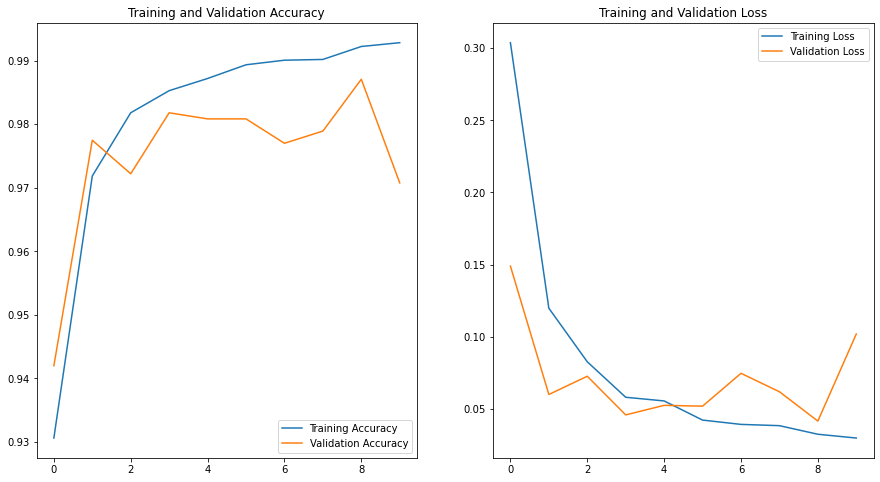

In [23]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()